In [1]:
import torch
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import MNIST, CIFAR10 
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, ConcatDataset
import detectors
import timm
import matplotlib.pyplot as plt
from tqdm import tqdm

/Users/bjbae/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
torch.manual_seed(0)

In [3]:
queries = [10000, 20000, 30000, 40000, 50000]

### Import Victim Model

In [4]:
pretrained_model = timm.create_model("resnet18_cifar10", pretrained=True)

knockoff_model_base = resnet50(weights=None)
knockoff_model = knockoff_model_base

### Import datasets and apply transforms

In [5]:
cifar_transform = transforms.Compose(
    [transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_transform = transforms.Compose(
    # Upscale MNIST images to match CIFAR images
    # Duplicate MNIST image channels to match CIFAR images
    [transforms.Resize(size=[32,32]),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_train = MNIST('./data', train=True, transform=mnist_transform, download=True)
mnist_test = MNIST('./data', train=False, transform=mnist_transform, download=True)
cifar_train= CIFAR10('./data', train=True, transform=cifar_transform, download=True)
cifar_test= CIFAR10('./data', train=False, transform=cifar_transform, download=True)


Files already downloaded and verified
Files already downloaded and verified


### Combine MNIST and CIFAR datasets for training and testing

In [6]:
mnist_cifar_train = ConcatDataset([mnist_train, cifar_train])
mnist_cifar_test = ConcatDataset([mnist_test, cifar_test])

In [7]:
mnist_cifar_train_loader = DataLoader(mnist_cifar_train, batch_size=4, shuffle=True)
mnist_cifar_test_loader = DataLoader(mnist_cifar_test, batch_size=4, shuffle=True)
cifar_test_loader = DataLoader(cifar_test, batch_size=4, shuffle=True)
mnist_test_loader = DataLoader(mnist_test, batch_size=4, shuffle=True)

In [8]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(knockoff_model.parameters())

In [9]:
def training_knockoff(pretrained_model, knockoff_model, num_queries, data_loader):
    knockoff_model.train()
    for _ in tqdm(range(num_queries)):
        # Every data instance is an input + label pair
        inputs, _ = next(iter(data_loader))

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Get label by querying from victim model
        softmax_outputs = pretrained_model(inputs)
        labels = torch.argmax(softmax_outputs, dim=1)

        # Make predictions for this batch
        outputs = knockoff_model(inputs)

        # Compute the loss and its gradients
        loss = loss_fn(outputs, labels)
        loss.backward()

        # Adjust learning weights
        optimizer.step()
    return knockoff_model


In [10]:
def testing_knockoff(pretrained_model, knockoff_model, data_loader):
    correct = 0
    count = 0
    knockoff_model.eval()
    for data in tqdm(data_loader):
        inputs, _ = data

        # Get output of victim model
        pretrained_softmax = pretrained_model(inputs)
        pretrained_output = torch.argmax(pretrained_softmax, dim=1)

        # Get output of knockoff model
        knockoff_softmax = knockoff_model(inputs)
        knockoff_output = torch.argmax(knockoff_softmax, dim=1)

        # Check if the two outputs match for each item in a batch
        for i in range(len(pretrained_output)):
            if pretrained_output[i] == knockoff_output[i]:
                correct += 1
            count += 1
    return correct/count

### Training Cycle

In [16]:
for num_query in queries:
    print("Queries:", num_query)
    knockoff_model = training_knockoff(pretrained_model, knockoff_model, num_query, mnist_cifar_train_loader)
    torch.save(knockoff_model.state_dict(), "./models/" + "model_" + str(num_query) + "_queries.pt")
    # Reset knockoff model to random weights
    knockoff_model = knockoff_model_base


Queries: 10000


100%|██████████| 10000/10000 [28:18<00:00,  5.89it/s] 


Queries: 20000


100%|██████████| 20000/20000 [47:06<00:00,  7.08it/s] 


Queries: 30000


100%|██████████| 30000/30000 [1:05:16<00:00,  7.66it/s]


Queries: 40000


100%|██████████| 40000/40000 [4:01:07<00:00,  2.76it/s]       


Queries: 50000


100%|██████████| 50000/50000 [1:49:55<00:00,  7.58it/s]  


### Testing Cycle

In [21]:
# initalize aggregate arrays for accuracies
cifar_acc_aggr = []
mnist_cifar_acc_aggr = []
mnist_acc_aggr = []

for num_query in queries:
    knockoff_model = knockoff_model_base
    knockoff_model.load_state_dict(torch.load("./models/" + "model_" + str(num_query) + "_queries.pt"))
    cifar_acc = testing_knockoff(pretrained_model, knockoff_model, cifar_test_loader)
    mnist_cifar_acc = testing_knockoff(pretrained_model, knockoff_model, mnist_cifar_test_loader)
    mnist_acc = testing_knockoff(pretrained_model, knockoff_model, mnist_test_loader)
    print("cifar_acc:", cifar_acc)
    print("mnist_cifar_acc:", mnist_cifar_acc)
    print("mnist_acc:", mnist_acc)
    cifar_acc_aggr.append(cifar_acc)
    mnist_cifar_acc_aggr.append(mnist_cifar_acc)
    mnist_acc_aggr.append(mnist_acc)

100%|██████████| 2500/2500 [02:03<00:00, 20.18it/s]


cifar_acc: 0.137
mnist_cifar_acc: 0.1984
mnist_acc: 0.189


100%|██████████| 2500/2500 [02:23<00:00, 17.37it/s]


cifar_acc: 0.1154
mnist_cifar_acc: 0.18735
mnist_acc: 0.1795


100%|██████████| 2500/2500 [01:48<00:00, 22.96it/s]


cifar_acc: 0.151
mnist_cifar_acc: 0.18895
mnist_acc: 0.1488


100%|██████████| 2500/2500 [02:17<00:00, 18.18it/s]


cifar_acc: 0.1797
mnist_cifar_acc: 0.23545
mnist_acc: 0.2127


100%|██████████| 2500/2500 [02:31<00:00, 16.49it/s]


cifar_acc: 0.161
mnist_cifar_acc: 0.21055
mnist_acc: 0.2185


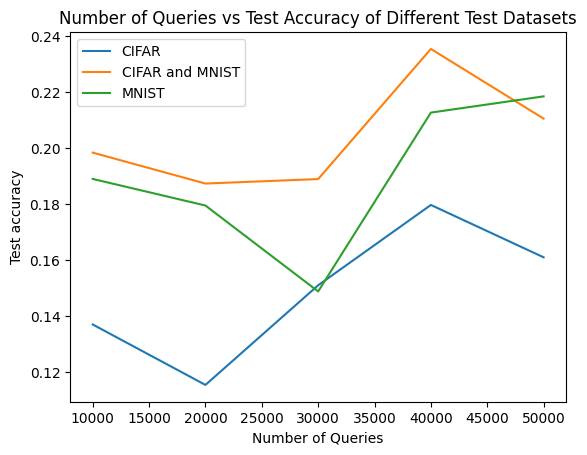

In [32]:
plt.plot(queries, cifar_acc_aggr, label="CIFAR")
plt.plot(queries, mnist_cifar_acc_aggr, label="CIFAR and MNIST")
plt.plot(queries, mnist_acc_aggr, label="MNIST")
plt.ylabel("Test accuracy")
plt.xlabel("Number of Queries")
plt.title("Number of Queries vs Test Accuracy of Different Test Datasets")
plt.legend()
plt.savefig("acc.png")